# Scaling and Power Transformation Demonstration
##### This notebook shows all scaled data , its skewness and Transformation
##### This notebook shows **original data**, **Box–Cox transformation**, and **Yeo–Johnson transformation** applied to right-skewed data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    PowerTransformer
)

sb.set(style="whitegrid")
np.random.seed(42)

### Generating a random dataset with some outliers and skew

In [2]:
n = 1000

data = pd.DataFrame({
    "annual_income": np.random.lognormal(mean=10.5, sigma=0.6, size=n),   # right-skewed
    "monthly_spend": np.random.lognormal(mean=8.2, sigma=0.7, size=n),
    "account_balance": np.concatenate([
        np.random.normal(20000, 15000, n-10),
        np.random.normal(300000, 80000, 10)  # extreme outliers
    ]),
    "credit_utilization": np.random.beta(2, 5, size=n),
    "num_transactions": np.random.poisson(20, size=n),
    "age": np.random.normal(40, 10, size=n)
})

data.head()

,annual_income,monthly_spend,account_balance,credit_utilization,num_transactions,age
0,48924.251431,9696.776655,9872.325875,0.066756,19,49.625029
1,33424.398935,6955.191082,17832.219939,0.105711,31,43.413443
2,53562.963185,3796.144627,8113.701185,0.535800,28,65.052652
3,90564.529961,2314.952055,15380.577055,0.159571,20,36.826508
4,31555.651338,5935.795417,-8404.220004,0.122880,16,41.388875


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   annual_income       1000 non-null   float64
 1   monthly_spend       1000 non-null   float64
 2   account_balance     1000 non-null   float64
 3   credit_utilization  1000 non-null   float64
 4   num_transactions    1000 non-null   int32  
 5   age                 1000 non-null   float64
dtypes: float64(5), int32(1)
memory usage: 43.1 KB


### lets see the skewness of the data and visulaize the same

annual_income         2.845997
monthly_spend         2.413738
account_balance       7.340992
credit_utilization    0.436088
num_transactions      0.319372
age                   0.015802
dtype: float64


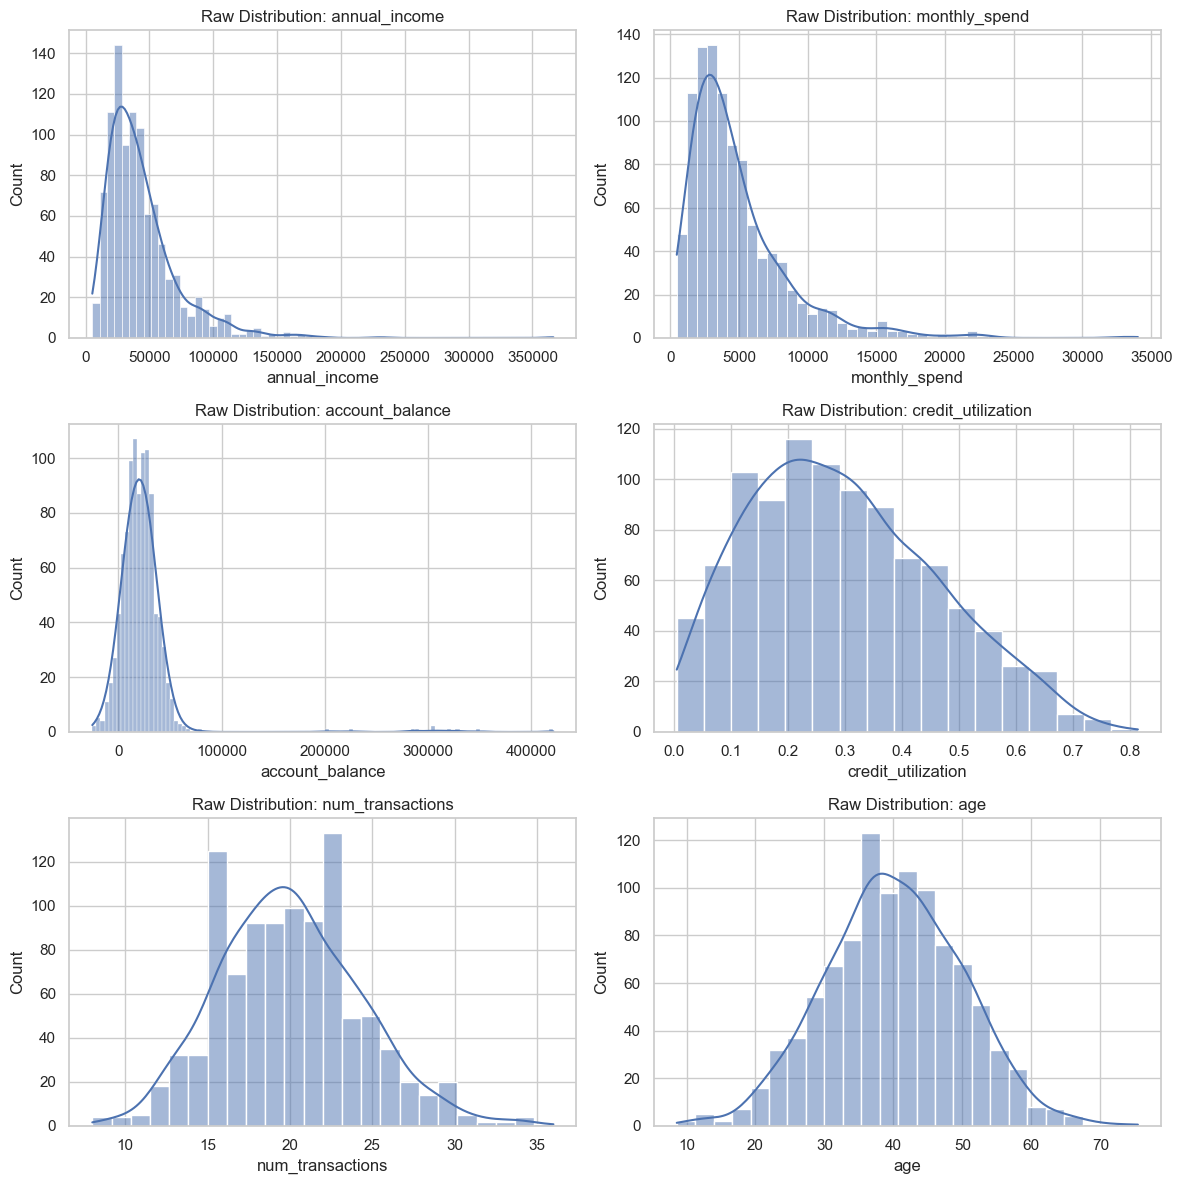

In [4]:
skewness_raw = data.skew()
print(skewness_raw)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, col in zip(axes, data.columns):
    sb.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f"Raw Distribution: {col}")

plt.tight_layout()
plt.show()

Credit_utilization is a  bounded feature that has natural lower and upper limits imposed by reality.

credit utilization=used credit/total credit limit
It cannot grow arbitrarily, Distribution shape is constrained and Scaling should preserve bounds
Best to use Min-Max scaler
Bounded features already live in a normalized space — our job is not to distort that meaning


### Scaling the SAME Feature with Different Scalers- example account_balance

In [5]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler()
}

scaled_balance = {}

for name, scaler in scalers.items():
    scaled_balance[name] = scaler.fit_transform(
        data[["account_balance"]]
    ).flatten()

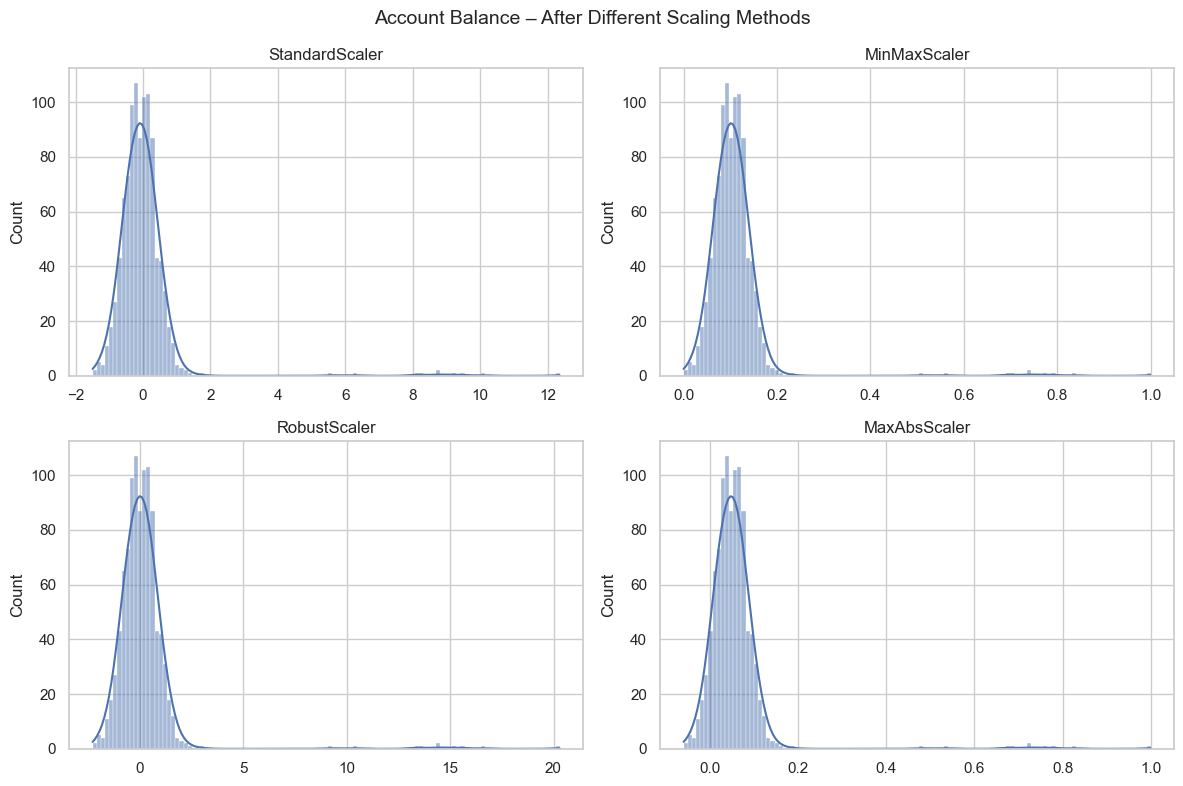

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, values) in zip(axes, scaled_balance.items()):
    sb.histplot(values.flatten(), kde=True, ax=ax)
    ax.set_title(name)

plt.suptitle("Account Balance – After Different Scaling Methods", fontsize=14)
plt.tight_layout()
plt.show()

### StandardScaler: sensitive to outliers. Mean =0 and Std. dev= 1. Never used for financial data
### Normalization: Extremely sensitive to outliers. One outlier will "squish" all other data into a tiny range (e.g., 0 to 0.01). Dangerous for diatance metrics. KNN loses neighbour dicrimination and K- means forms unstable clusters. It is good for Bounded varaibles, image data (pixel)
### Robust Scaling: Uses It uses the Median and Interquartile Range instead of the Mean. Resistant to outliers and Outliers do not influence the scaling of the "normal" data points. Best for heavy tailed data. It does not remove outlier, it only reduce their influence
### Max Absolute scalar: Similar to Min-Max, the maximum value dictates the scale.Preserves Sign and Useful for sparce data. Common is Linear SVM and logistic regression 


## Skewness after scaling? Any difference?

In [7]:
scaled_skewness = {
    name: pd.Series(values).skew()
    for name, values in scaled_balance.items()
}

pd.DataFrame.from_dict(
    scaled_skewness, orient="index", columns=["Skewness"]
)

,Skewness
StandardScaler,7.340992
MinMaxScaler,7.340992
RobustScaler,7.340992
MaxAbsScaler,7.340992


### Scaling does not change skewness.

### What should we do to change skewness?

Skewness before: 2.8459970381805353
Skewness after log: 0.11703105483078653


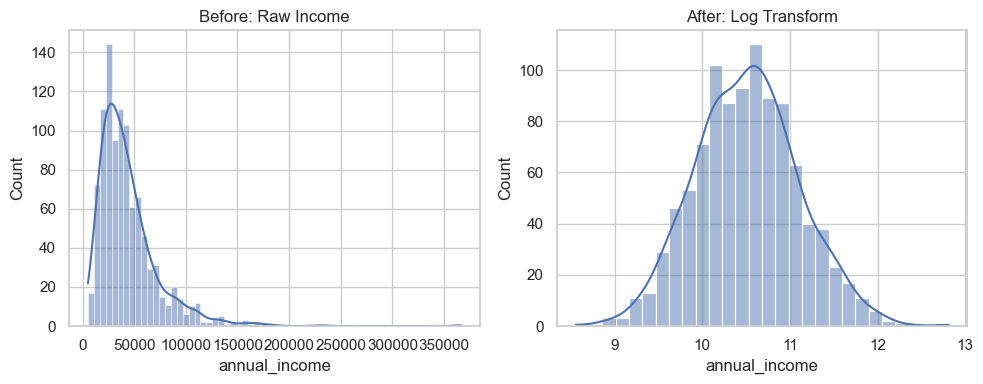

In [8]:

#The annual_income had a skew above 2 and we need to reduce the skew. Lets use log operation (natural logarithm) as this is a postive skew

log_income = np.log1p(data["annual_income"])

print("Skewness before:", data["annual_income"].skew())
print("Skewness after log:", log_income.skew())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sb.histplot(data["annual_income"], kde=True, ax=axes[0])
axes[0].set_title("Before: Raw Income")

sb.histplot(log_income, kde=True, ax=axes[1])
axes[1].set_title("After: Log Transform")

plt.tight_layout()
plt.show()

#### We could reduce the skew of annual_income using log operation
#### Can we reduce it further? As Annual income is a positive data, Box-cox transformation is good for the same.

Skewness before: 2.8459970381805353
Skewness after Box-Cox: -0.00042751020740515466


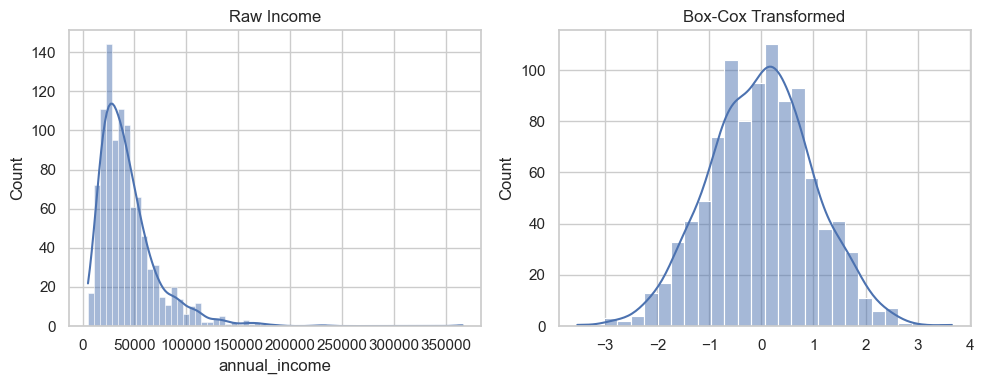

In [9]:
boxcox = PowerTransformer(method="box-cox")
income_boxcox = boxcox.fit_transform(data[["annual_income"]]).flatten()

print("Skewness before:", data["annual_income"].skew())
print("Skewness after Box-Cox:", pd.Series(income_boxcox).skew())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sb.histplot(data["annual_income"], kde=True, ax=axes[0])
axes[0].set_title("Raw Income")

sb.histplot(income_boxcox.flatten(), kde=True, ax=axes[1])
axes[1].set_title("Box-Cox Transformed")

plt.tight_layout()
plt.show()

### Look at the equation of box-cox from slides
### Box-Cox learns lamda automatically and it optimizes Gaussianity and strictly for positive data

## For account_balance data , it is postive and negative hence cannot use Box_cox (need Yeo Johnson)

Skewness before: 7.340991822810185
Skewness after Yeo-Johnson: 4.672839048145171


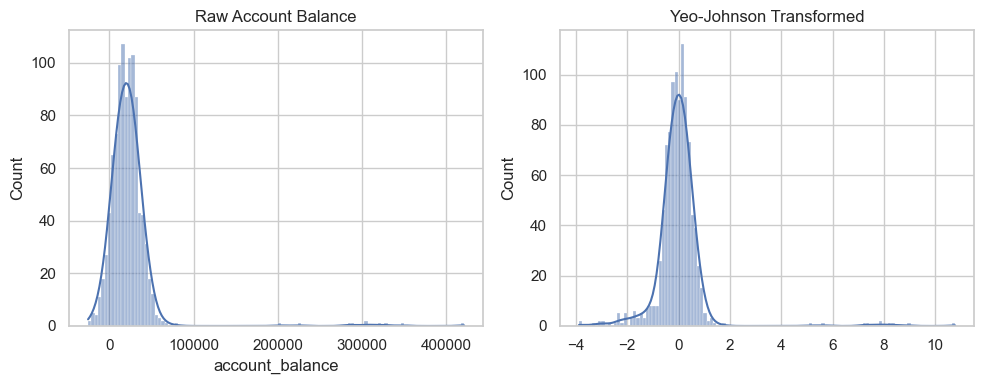

In [10]:
yj = PowerTransformer(method="yeo-johnson")
balance_yj = yj.fit_transform(data[["account_balance"]]).flatten()

print("Skewness before:", data["account_balance"].skew())
print("Skewness after Yeo-Johnson:", pd.Series(balance_yj).skew())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sb.histplot(data["account_balance"], kde=True, ax=axes[0])
axes[0].set_title("Raw Account Balance")

sb.histplot(balance_yj.flatten(), kde=True, ax=axes[1])
axes[1].set_title("Yeo-Johnson Transformed")

plt.tight_layout()
plt.show()

### Yeo Johnson handles zeros and negatives and is preferred for financial data 

### Lets take another data monthly_spend. Its skewness is 2.41. Lets remove its skew using log transformation and scale it using standard scaler.
### note that we need trnasformation first and then scaling

Mean after log: 8.249919808309901
Std after log: 0.697979718387072
Skewness after log: -0.04865375579691859
Mean after scaling: 1.0675904604795505e-15
Std after scaling: 1.0
Skewness after scaling: -0.04865375579692175


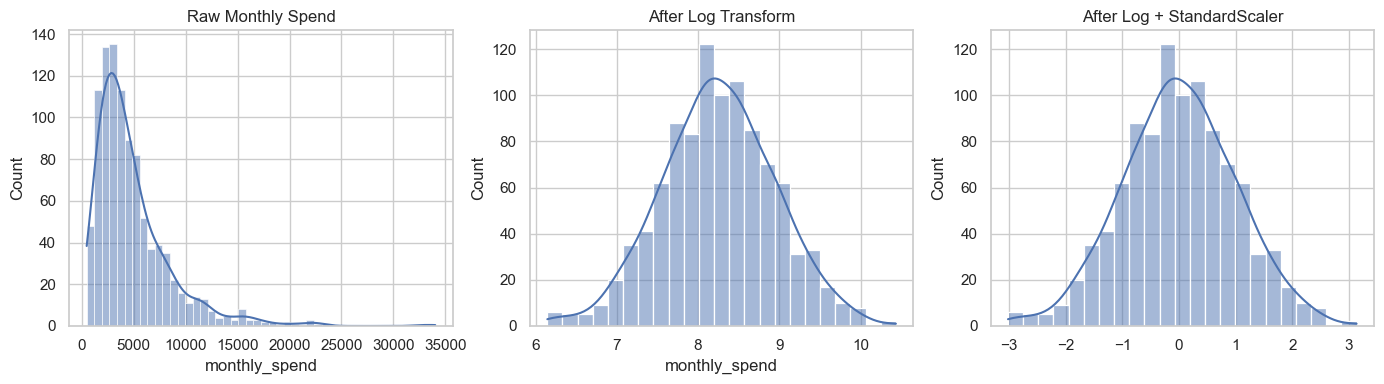

In [11]:
log_spend = np.log1p(data["monthly_spend"])

print("Mean after log:", log_spend.mean())
print("Std after log:", log_spend.std())
print("Skewness after log:", log_spend.skew())

log_spend_scaled = StandardScaler().fit_transform(
    log_spend.values.reshape(-1, 1)
).flatten()

print("Mean after scaling:", log_spend_scaled.mean())
print("Std after scaling:", log_spend_scaled.std())
print("Skewness after scaling:", pd.Series(log_spend_scaled).skew())

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sb.histplot(data["monthly_spend"], kde=True, ax=axes[0])
axes[0].set_title("Raw Monthly Spend")

sb.histplot(log_spend, kde=True, ax=axes[1])
axes[1].set_title("After Log Transform")

sb.histplot(log_spend_scaled, kde=True, ax=axes[2])
axes[2].set_title("After Log + StandardScaler")

plt.tight_layout()
plt.show()

### First fix the shape and then fix scaling and never reverse  it
### What happens if you scale first :Skewness remains unchanged, Mean & variance unreliable and Outliers still dominate
## Analogy  You don’t resize a crooked image — you straighten it first

### Q1: Which feature might break distance based models (annual_income, monthly_spend, account_balance,age)